In [122]:
class classes:    
    classes_copernicus = [ 'NoData','Closed forest',
                                     'Open forest',
                                     'Shrubs',
                                     'Herbaceous vegetation',
                                     'Bare / sparse vegetation',
                                     'Urban / built up',
                                     'Cropland',
                                     'Water bodies',
                                     'Herbaceous wetland' ]

    colors_copernicus = ['#ababab', '#086a10',
                                    '#54a708',
                                    '#ffbb22',
                                    '#ffff4c',
                                    '#b4b4b4',
                                    '#fa0000',
                                    '#f096ff',
                                    '#0032c8',
                                    '#0096a0']

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import matplotlib 
import matplotlib.pyplot as plt
# from skimage.transform import resize

%matplotlib inline

In [2]:
feature_format= {
            'x250/data': tf.FixedLenFeature([], tf.string),
            'x250/shape': tf.FixedLenFeature([4], tf.int64),
            'x500/data': tf.FixedLenFeature([], tf.string),
            'x500/shape': tf.FixedLenFeature([4], tf.int64),
            'dates/doy': tf.FixedLenFeature([], tf.string),
            'dates/year': tf.FixedLenFeature([], tf.string),
            'dates/shape': tf.FixedLenFeature([1], tf.int64),
            'labels/data': tf.FixedLenFeature([], tf.string),
            'labels/shape': tf.FixedLenFeature([4], tf.int64),
            'labels_frac/data': tf.FixedLenFeature([], tf.string),
            'labels_frac/shape': tf.FixedLenFeature([4], tf.int64)
}

In [3]:
def read2(filenames):
    """ depricated! """

    if isinstance(filenames,list):
        filename_queue = tf.train.string_input_producer(filenames, num_epochs=None)
    elif isinstance(filenames,tf.FIFOQueue):
        filename_queue = filenames
    else:
        print ("please insert either list or tf.FIFOQueue")

#         reader = tf.TFRecordReader()
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    reader = tf.TFRecordReader(options=options)

    f, serialized_example = reader.read(filename_queue)

    feature = tf.parse_single_sequence_example(serialized_example, feature_format)

    # decode and reshape
    x250 = tf.reshape(tf.decode_raw(feature[0]['x250/data'], tf.int64), tf.cast(feature[0]['x250/shape'], tf.int32))
    x500 = tf.reshape(tf.decode_raw(feature[0]['x500/data'], tf.int64), tf.cast(feature[0]['x500/shape'], tf.int32))

    doy = tf.reshape(tf.decode_raw(feature[0]['dates/doy'], tf.int64), tf.cast(feature[0]['dates/shape'], tf.int32))
    year = tf.reshape(tf.decode_raw(feature[0]['dates/year'], tf.int64), tf.cast(feature[0]['dates/shape'], tf.int32))

    labels = tf.reshape(tf.decode_raw(feature[0]['labels/data'], tf.int64), tf.cast(feature[0]['labels/shape'], tf.int32))
    labels_frac = tf.reshape(tf.decode_raw(feature[0]['labels_frac/data'], tf.float32), tf.cast(feature[0]['labels_frac/shape'], tf.int32))

    return x250, x500, doy, year, labels, labels_frac

In [5]:
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

def read_and_return2(filenames):
    """ depricated! """

    # get feature operation containing
    feature_op = read2(filenames)

    with tf.Session(config=config) as sess:

        tf.global_variables_initializer()

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        return sess.run(feature_op)

In [ ]:
##porto dos gauchos 0_1_585
##pucallpa 0_1_508

In [88]:
filename = r'F:\acoca\research\gee\dataset\AMZ_local\MOD09_250m500m\combine\384\data15\AMZtest2_p384k0-508.gz'

In [34]:
filename = r'F:\acoca\research\gee\dataset\AMZ_local\MOD09_250m500m\gz\384\multiple\data15\0_0_563.gz'

In [6]:
filename = r'F:\acoca\research\gee\dataset\tile_0_630\gz\384\multiple\data15\0_0_0.gz'

In [89]:
x250__, x500__, doy__, year__, labels__, labels_frac__ = read_and_return2([filename])

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_4/input_producer_4_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer_4, input_producer_4/RandomShuffle)]]


No handles with labels found to put in legend.


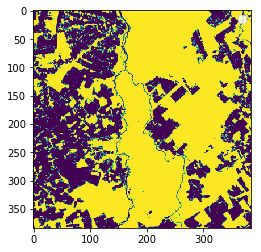

In [58]:
plt.imshow(labels_frac__[0,:,:,3])
plt.legend()

In [61]:
def frac_copernicus(thsld, frac_array):
    #aggregate forest types
    closedf = np.sum(frac_array[:,:,:,1:7],axis=3)
    openf = np.sum(frac_array[:,:,:,7:13],axis=3)
    
    #create dimensions to append
    nodata=np.expand_dims(frac_array[:,:,:,0],axis=3)
    closedf=np.expand_dims(closedf,axis=3)
    openf=np.expand_dims(openf,axis=3)
    
    #append
    nodata_closedf = np.append(nodata,closedf,axis=3)
    forest = np.append(nodata_closedf,openf,axis=3)
    newcopernicus_frac = np.append(forest,frac_array[:,:,:,13:],axis=3)
    
    alllabels = np.zeros((1,frac_array.shape[1],frac_array.shape[2]))

    #negative probability to find second
    arr_tmp = np.copy(newcopernicus_frac)
    arr_tmp[0,:,:,1]=-0.1

    alllabels_tmp = np.argmax(arr_tmp, axis=3)
    alllabels_ori = np.argmax(newcopernicus_frac, axis=3) 
    alllabels_mask = np.where(newcopernicus_frac[0,:,:,1]<thsld, alllabels_tmp, alllabels)
    
    alllabels_final = np.where(newcopernicus_frac[0,:,:,1]>=thsld, alllabels_ori, alllabels_mask)
    alllabels_original = np.argmax(newcopernicus_frac, axis=3)
    
    return(alllabels_final)

In [87]:
MT = labels_frac__

In [90]:
UY = labels_frac__

In [95]:
def prepare_frac(array):
    fractions = np.arange(0.1, 1.1, 0.1)
    result = [frac_copernicus(f, array) for f in fractions]
    a = np.array(result)
    a = np.reshape(result,(a.shape[0]*a.shape[1],a.shape[2],a.shape[3]))
    return a

In [96]:
MT_arr = prepare_frac(MT)

In [97]:
UY_arr = prepare_frac(UY)

In [98]:
fn_list = [UY_arr, MT_arr]

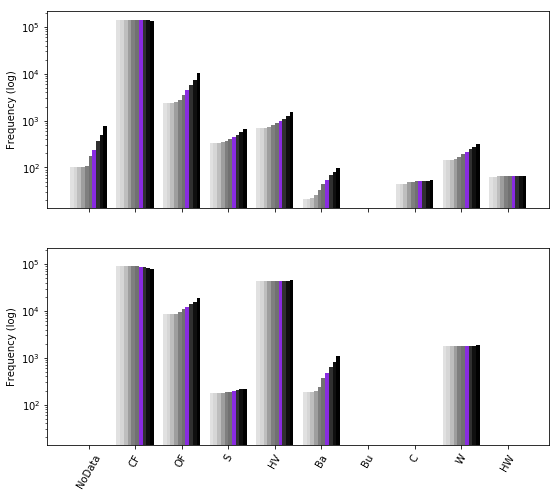

In [140]:
import matplotlib as mpl

nbins = 11

kwargs = {'log': True,
          'bins': np.arange(nbins) - 0.5}

# labels = ['NoData','CF','OF','S','HV','HW','ML','Ba','C','Bu','SI','PW','OS']
labels = ['NoData','CF','OF','S','HV','Ba','Bu','C','W','HW']

fractions = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']

cmap = mpl.cm.Greys(np.linspace(0,1,20))
highlight = np.array([138/256, 43/256, 226/256, 1])
cmap[14, :] = highlight
newcmp = mpl.colors.ListedColormap(cmap[4:,:-1])

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(9, 8))

axs = axes.flatten()

# xtick_labels = ['Class-%d' % (f+1) for f in range(labels)]
xticks = [i for i in range(len(labels))]

for i, arr in enumerate(fn_list):
    rng = np.nanmin(arr), np.nanmax(arr)

    if len(arr.shape) is 2:
        arr = np.expand_dims(arr.flatten(), 0).T
    else:
        arr = arr.reshape(arr.shape[0], -1).T

    n, bins, patches = axs[i].hist(arr, label=fractions, **kwargs)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', newcmp(c))

    axs[i].set_xticks(xticks)
    axs[i].set_ylabel("Frequency (log)")
    # ax.legend(legend,  loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=10)
    axs[i].set_title('')
    axs[i].set_xticklabels(labels, rotation=60)

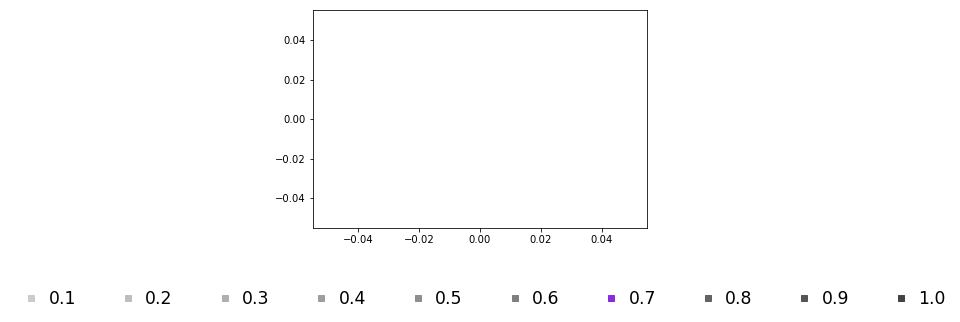

In [146]:
cmap = mpl.cm.Greys(np.linspace(0,1,20))
highlight = np.array([138/256, 43/256, 226/256, 1])
cmap[12, :] = highlight
newcmp = mpl.colors.ListedColormap(cmap[6:,:-1])

colors = []
for i in range(newcmp.N):
    rgb = newcmp(i) # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

labels = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(len(colors))]
legend = plt.legend(bbox_to_anchor=(0.5, -0.4), handletextpad=0.001, frameon=False, loc='lower center', borderaxespad=0., labels = labels, ncol=10, fontsize='xx-large')

# Extracting handles and labels

def export_legend(legend, filename="legend_" + scheme + "_fraction.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

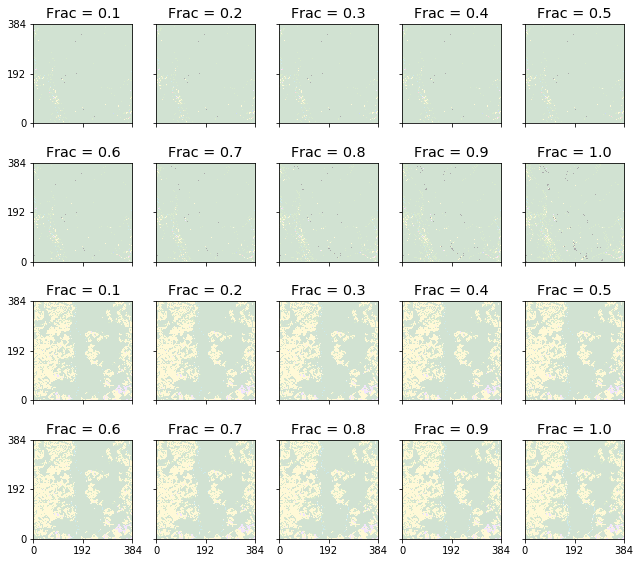

In [149]:
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True, figsize=(9, 8))

axs = axes.flatten()

tar_val = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0', '0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']

colors = classes.colors_copernicus 
n_labels = 13

colormap = matplotlib.colors.LinearSegmentedColormap.from_list(range(n_labels),colors)

merge_image = np.vstack((UY_arr, MT_arr))

label_list = ['0', '192', '384']

for i, img_s in enumerate(merge_image):
    masked_array = np.ma.array(img_s, mask= (img_s != 0))
#     masked_array = np.ma.array(img_s, mask=((img_s != 1) & (img_s != 2)))
    axs[i].imshow(img_s, cmap = colormap, interpolation='none', vmin=0, vmax=len(colors),  alpha=0.2, extent=extent)
    axs[i].imshow(masked_array, cmap = colormap, interpolation='none', vmin=0, vmax=len(colors),  alpha=1, extent=extent)
    axs[i].set_title('Frac = {}'.format(tar_val[i]), fontsize='x-large')
    axs[i].set_xticks([0,192,384])
    axs[i].set_yticks([0,192,384])
    axs[i].set_xticklabels(label_list)
    axs[i].set_yticklabels(label_list)

fig.subplots_adjust(wspace=0.05, hspace=0.01)
fig.tight_layout()

('NoData', 'NoData')
('Closed forest', 'CF')
('Open forest', 'OF')
('Shrubs', 'S')
('Herbaceous vegetation', 'HV')
('Bare / sparse vegetation', 'Ba')
('Urban / built up', 'Bu')
('Cropland', 'C')
('Water bodies', 'W')
('Herbaceous wetland', 'HW')


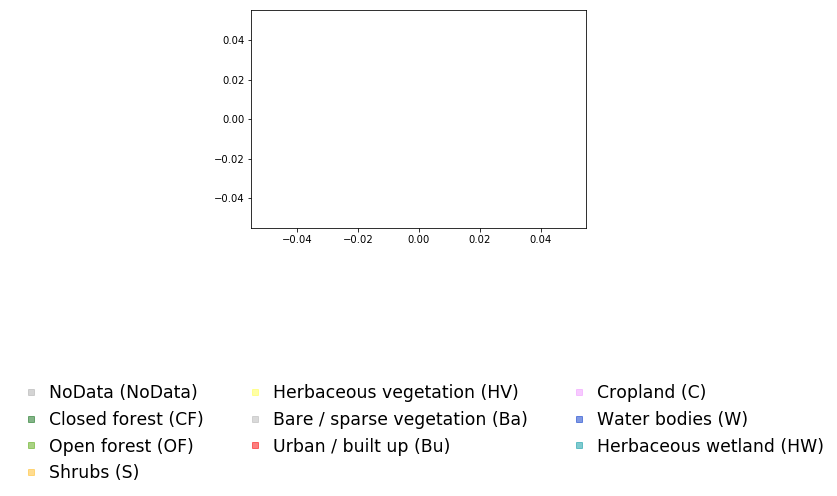

In [124]:
import numpy as np

labels_acro = ['NoData','CF','OF','S','HV','Ba','Bu','C','W','HW']

scheme = 'Copernicusraw'

if scheme == 'Copernicusraw':
    colors = classes.colors_copernicus
    labels = classes.classes_copernicus 

for i in zip(labels,labels_acro):
    print(i)

labels_all = [x+' ('+y+')' for x,y in zip(labels,labels_acro)]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(len(colors))]
legend = plt.legend(bbox_to_anchor=(0.5, -1.2), handletextpad=0.001, frameon=False, loc='lower center', borderaxespad=0., labels = labels_all, ncol=3, fontsize='xx-large')
for lh in legend.legendHandles: 
    lh._legmarker.set_alpha(0.5)

# Extracting handles and labels

def export_legend(legend, filename="legend_" + scheme + ".png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()